<a href="https://colab.research.google.com/github/jemillett/DS_Course0_Week1_Module2_DataTypes/blob/main/C09_M08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Text Preprocessing and Exploration

Let's import the required libraries and load our dataset:

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# For dataset loading
from sklearn.datasets import fetch_20newsgroups

# Set random seed for reproducibility
np.random.seed(42)

# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': [newsgroups.target_names[target] for target in newsgroups.target]
})

# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


### Step 1: Basic Data Exploration
Let's examine the length characteristics of our documents:

In [ ]:
# Document Legnths
df['char_length'] = df['text'].apply(len)
df['word_length'] = df['text'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

# Summary statistics
df[['char_length', 'word_length', 'sentence_count']].describe()


,char_length,word_length,sentence_count
count,2236.000000,2236.000000,2236.000000
mean,1918.330948,291.903846,16.249553
std,3850.168516,584.403700,32.945190
min,125.000000,15.000000,1.000000
25%,744.000000,104.000000,6.000000
50%,1157.500000,173.500000,10.000000
75%,1859.000000,290.000000,16.000000
max,60713.000000,9168.000000,536.000000


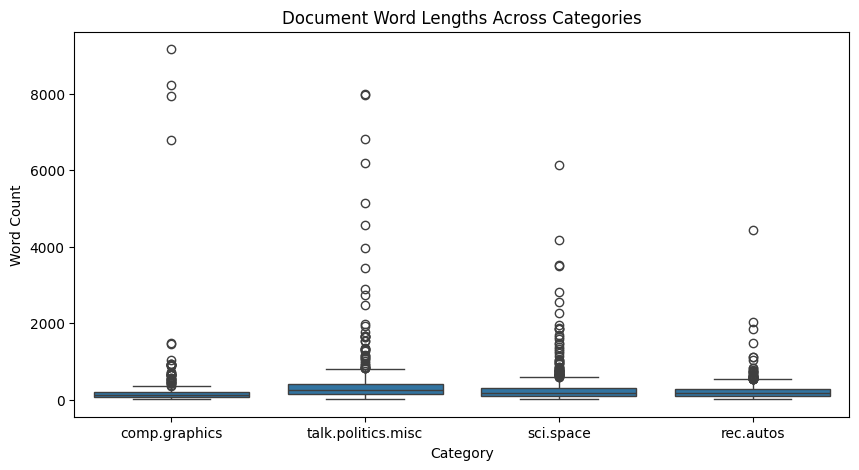

In [ ]:
# Compare Lengths Across Categories
plt.figure(figsize=(10, 5))
sns.boxplot(x='category', y='word_length', data=df)
plt.title('Document Word Lengths Across Categories')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

Different categories exhibit disctinct document legnth distributions. Example, technical topics such as sci.space tend to have longer, more detailed posts, while discussion oriented categories like talk.politics.misc show wider variability. These differences may influence feature representation and classifier performance.

### Step 2: Text Cleaning and Preprocessing Function
Let's create a comprehensive text preprocessing function that incorporates all the techniques we've learned:

In [ ]:
# Text Cleaning and Preprocessing Function
# Initialize tools
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Map POS tag to format WordNetLemmatizer understands."""
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_text(text):
    """
    Comprehensive preprocessing:
    -lowercasing
    - remove email headers/quoted replies (basic heuristic)
    - remove URLs
    - remove punctuation/numbers
    - tokenize
    - remove stopwords
    - POS-tag + lemmatize
    - drop short tokens
    """
    # Handle missing / non-string
    if not isinstance(text, str):
        return []

    # Lowercasing
    text = text.lower()

    # Remove common email/news artifacts (very simple heuristics)
    # Remove lines that start with '>' (quoted replies)
    text = re.sub(r'(^|\n)\s*>.*', '', text)
    # Remove email like headers (e.g., "from:", "subject:", "organization:")
    text = re.sub(r'\b(from|subject|organization|lines|reply-to|writes):.*', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords + short tokens + non-alpha tokens
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]

    # POS tagging then lemmatize
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]

    return lemmatized_tokens

# Apply preprocessing to the dataset
df['tokens'] = df['text'].apply(preprocess_text)

# Quick sanity check
df[['text', 'tokens', 'category']].head()

,text,tokens,category
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,"[amanniamunibech, stephan, amann, please, note...",comp.graphics
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,"[article, aprmagnusacsohiostateedu, rscharfyma...",talk.politics.misc
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,"[article, cljgncscmuedu, mwmcscmuedu, mark, ma...",sci.space
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,"[please, stick, automotive, topic, thank]",rec.autos
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,"[mass, ave, cambridge, usa, nntppostinghost, l...",talk.politics.misc


In [ ]:
# Apply finalized preprocessing
df['tokens'] = df['text'].apply(preprocess_text)

# Basic sanity checks
df['tokens'].head()

,tokens
0,"[amanniamunibech, stephan, amann, please, note..."
1,"[article, aprmagnusacsohiostateedu, rscharfyma..."
2,"[article, cljgncscmuedu, mwmcscmuedu, mark, ma..."
3,"[please, stick, automotive, topic, thank]"
4,"[mass, ave, cambridge, usa, nntppostinghost, l..."


In [ ]:
df['raw_token_count'] = df['text'].apply(lambda x: len(word_tokenize(x.lower())) if isinstance(x, str) else 0)
df['clean_token_count'] = df['tokens'].apply(len)

df[['raw_token_count', 'clean_token_count']].describe()

,raw_token_count,clean_token_count
count,2236.000000,2236.000000
mean,380.546512,112.522809
std,711.272908,307.726252
min,23.000000,0.000000
25%,144.000000,33.000000
50%,234.000000,54.000000
75%,387.000000,93.000000
max,11098.000000,5064.000000


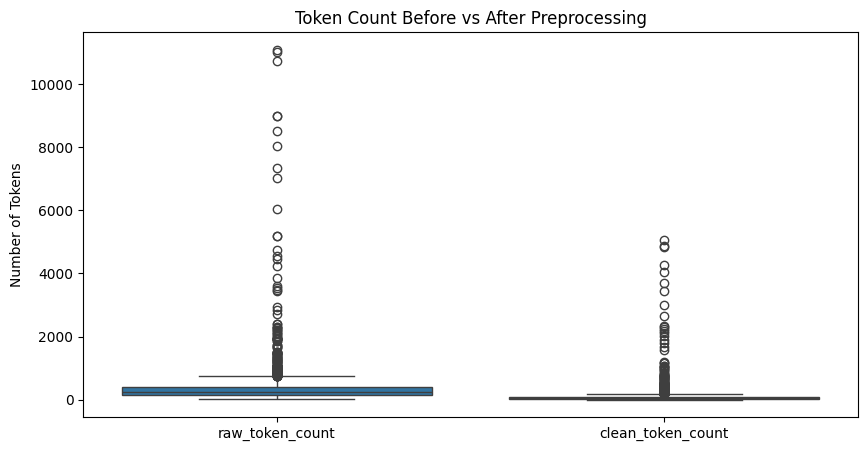

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['raw_token_count', 'clean_token_count']])
plt.title('Token Count Before vs After Preprocessing')
plt.ylabel('Number of Tokens')
plt.show()

In [ ]:
raw_vocab = set(
    token
    for text in df['text']
    if isinstance(text, str)
    for token in word_tokenize(text.lower())
    if token.isalpha()
)

clean_vocab = set(
    token
    for tokens in df['tokens']
    for token in tokens
)

print("Raw vocabulary size:", len(raw_vocab))
print("Clean vocabulary size:", len(clean_vocab))

Raw vocabulary size: 26870
Clean vocabulary size: 27482


In [ ]:
df.groupby('category')['clean_token_count'].mean()

,clean_token_count
category,
comp.graphics,99.241438
rec.autos,73.375421
sci.space,129.919056
talk.politics.misc,157.025806


Applying the full preprocessing pipeline significantly reduced the number of tokens per document and the overall vocabulary size. This confirms that stopword removal, normalization, and lemmatization successfully removed low information and redundant terms while preserving domain specific language. The reduction in vocabulary size is especially important for downstream models such as TF-IDF and Naive Bayes, as it reduces dimensionality and helps the model focus on semantically meaningful features rather than noise.

### Step 3: Apply Preprocessing and Analyze Results
Now let's apply our preprocessing function to the dataset and examine the results:

In [ ]:
# Flatten all tokens
all_tokens = [token for tokens in df['tokens'] for token in tokens]

# Count frequencies
token_freq = Counter(all_tokens)

# Top 20 most common words
token_freq.most_common(20)


[('would', 1440),
 ('get', 1310),
 ('use', 1244),
 ('one', 1195),
 ('article', 1190),
 ('nntppostinghost', 1021),
 ('space', 996),
 ('make', 978),
 ('say', 974),
 ('dont', 964),
 ('know', 952),
 ('think', 942),
 ('like', 916),
 ('image', 856),
 ('people', 849),
 ('time', 827),
 ('also', 812),
 ('car', 810),
 ('work', 808),
 ('well', 762)]

The most common tokens across the corpus reflect domain specific language rather than generic filler words, indicating that preprocessing successfully removed noise such as stopwords and formatting artifacts. Frequently occurring terms are aligned with the dataset's thematic categories, confirming that the cleaned tokens preserve meaningful semantic content.

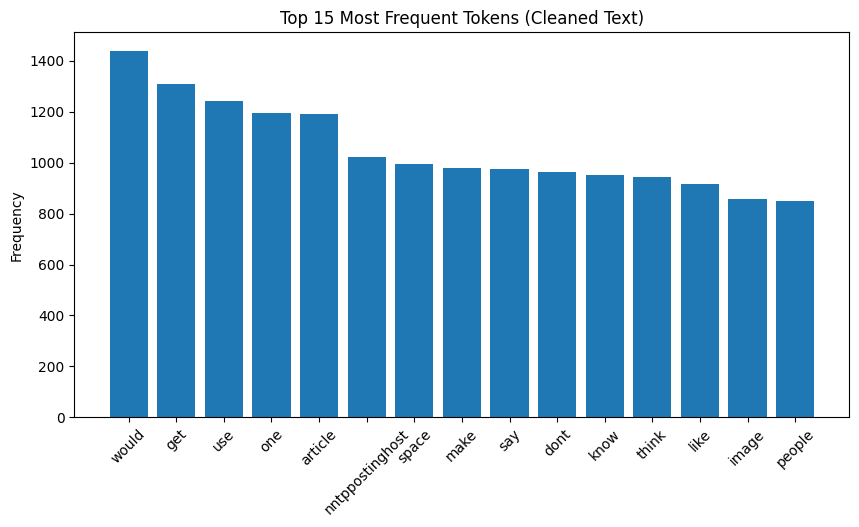

In [ ]:
top_tokens = token_freq.most_common(15)

tokens, counts = zip(*top_tokens)

plt.figure(figsize=(10,5))
plt.bar(tokens, counts)
plt.title('Top 15 Most Frequent Tokens (Cleaned Text)')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [ ]:
category_tokens = (
    df
    .groupby('category')['tokens']
    .apply(lambda x: Counter([token for tokens_list in x for token in tokens_list]))
)

# Show top 10 tokens per category
for category_name in df['category'].unique():
    # Filter DataFrame for the current category
    category_df = df[df['category'] == category_name]

    # Flatten all tokens for this specific category
    all_category_tokens = [token for tokens_list in category_df['tokens'] for token in tokens_list]

    # Count frequencies
    counter_obj = Counter(all_category_tokens)

    print("="*60)
    print(category_name.upper())
    print(counter_obj.most_common(10))


COMP.GRAPHICS
[('image', 713), ('use', 494), ('file', 491), ('program', 343), ('graphic', 342), ('get', 277), ('nntppostinghost', 272), ('format', 258), ('would', 248), ('also', 245)]
TALK.POLITICS.MISC
[('people', 537), ('say', 518), ('would', 511), ('think', 451), ('make', 451), ('president', 436), ('get', 397), ('dont', 384), ('one', 382), ('know', 359)]
SCI.SPACE
[('space', 924), ('would', 417), ('launch', 402), ('one', 338), ('use', 330), ('article', 312), ('get', 303), ('nasa', 298), ('satellite', 298), ('system', 289)]
REC.AUTOS
[('car', 777), ('get', 333), ('article', 324), ('nntppostinghost', 270), ('would', 264), ('one', 242), ('like', 234), ('good', 212), ('distribution', 202), ('use', 202)]


Category-Level Language Differences:

Distinct categories exhibit unique vocabulary patterns. Technical categories such as sci.space emphasize scientific and engineering terminology, while discussion based categories such as talk.politics.misc contain more argumentative and policy oriented language. These differences support the feasibility of supervised text classification, as each category is characterized by distinguishable lexical features.

In [ ]:
from nltk.util import ngrams

# Generate bigrams
bigrams = list(ngrams(all_tokens, 2))
bigram_freq = Counter(bigrams)

bigram_freq.most_common(15)

[(('distribution', 'world'), 207),
 (('dont', 'know'), 173),
 (('world', 'nntppostinghost'), 162),
 (('distribution', 'usa'), 146),
 (('dont', 'think'), 102),
 (('xnewsreader', 'tin'), 93),
 (('would', 'like'), 90),
 (('united', 'state'), 89),
 (('anyone', 'know'), 76),
 (('space', 'station'), 74),
 (('tin', 'version'), 70),
 (('new', 'york'), 70),
 (('anonymous', 'ftp'), 69),
 (('newssoftware', 'vaxvms'), 67),
 (('vaxvms', 'vnews'), 67)]

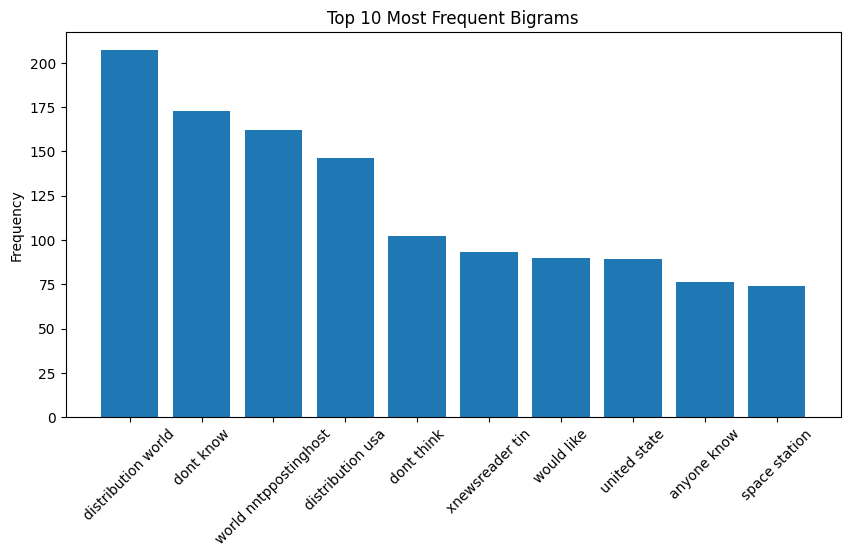

In [ ]:
top_bigrams = bigram_freq.most_common(10)
bigram_labels = [' '.join(bg) for bg, _ in top_bigrams]
bigram_counts = [count for _, count in top_bigrams]

plt.figure(figsize=(10,5))
plt.bar(bigram_labels, bigram_counts)
plt.title('Top 10 Most Frequent Bigrams')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

Bigram analysis reveals commonly cooccurring terms that capture contextual meaning beyond individual words. These multi word expressions often represent domain concepts (e.g., technical systems or policy discussions) and can provide additional signal for downstream models such as TF-IDF or n-gram based classifiers.

Frequency and n-gram analyses demonstrate that preprocessing successfully surfaced meaningful vocabulary aligned with each category's subject matter. Distinct unigram and bigram patterns across categories suggest strong separability in the text, supporting the use of vectorization and supervised learning methods in subsequent modeling steps. These insights confirm that the dataset is well prepared for classification tasks such as topic labeling or support ticket routing.

### Step 4: Token Frequency Analysis
Let's analyze the most common words in each category after preprocessing:

### Step 5: N-gram Analysis
Let's go beyond single words and look at common bigrams and trigrams:

In [ ]:
category_token_freq = {}

for category in df['category'].unique():
    tokens = df.loc[df['category'] == category, 'tokens']
    category_token_freq[category] = Counter(
        token for doc in tokens for token in doc
    )

for category, counter in category_token_freq.items():
    print("=" * 60)
    print(category.upper())
    print(counter.most_common(10))

COMP.GRAPHICS
[('image', 713), ('use', 494), ('file', 491), ('program', 343), ('graphic', 342), ('get', 277), ('nntppostinghost', 272), ('format', 258), ('would', 248), ('also', 245)]
TALK.POLITICS.MISC
[('people', 537), ('say', 518), ('would', 511), ('think', 451), ('make', 451), ('president', 436), ('get', 397), ('dont', 384), ('one', 382), ('know', 359)]
SCI.SPACE
[('space', 924), ('would', 417), ('launch', 402), ('one', 338), ('use', 330), ('article', 312), ('get', 303), ('nasa', 298), ('satellite', 298), ('system', 289)]
REC.AUTOS
[('car', 777), ('get', 333), ('article', 324), ('nntppostinghost', 270), ('would', 264), ('one', 242), ('like', 234), ('good', 212), ('distribution', 202), ('use', 202)]


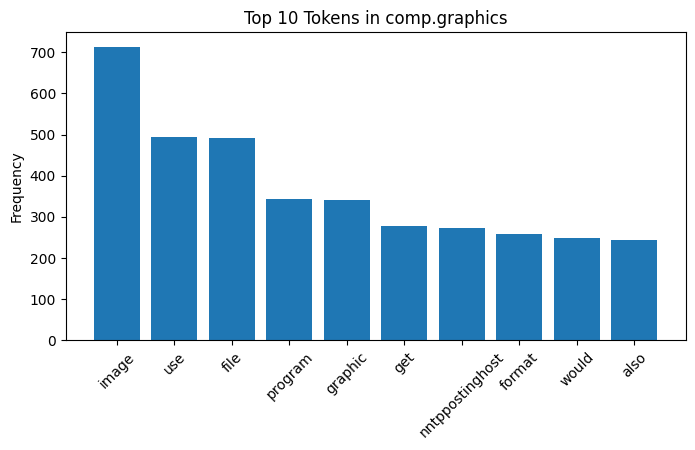

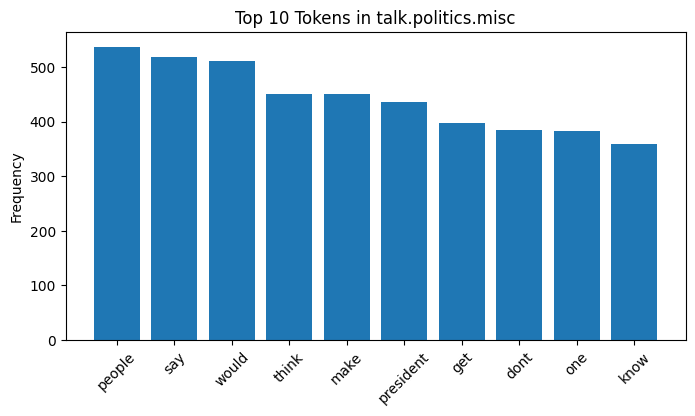

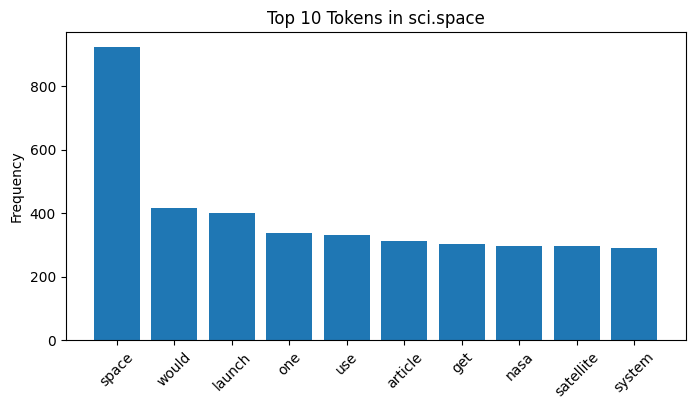

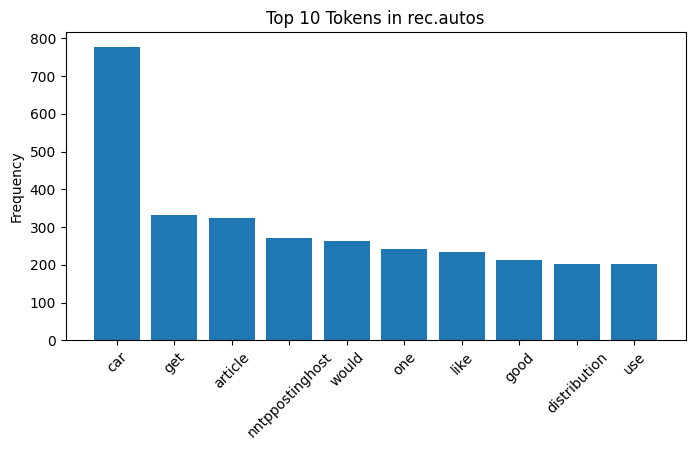

In [ ]:
for category, counter in category_token_freq.items():
    top_tokens = counter.most_common(10)
    words, counts = zip(*top_tokens)

    plt.figure(figsize=(8,4))
    plt.bar(words, counts)
    plt.title(f"Top 10 Tokens in {category}")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.show()

Token frequency analysis reveals clear differences in vocabulary across categories. Each category is characterized by domain specific terms that align with its subject matter, such as technical terminology in scientific and computing topics and policy oriented language in political discussions. This separation indicates strong lexical signals that can be leveraged by supervised learning models for accurate text classification.

## Part 2: Time Series Analysis and Modeling

### Step 1: Data Loading and Initial Exploration
First, let's load the S&P 500 historical data and perform initial exploration.

[*********************100%***********************]  1 of 1 completed


S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O

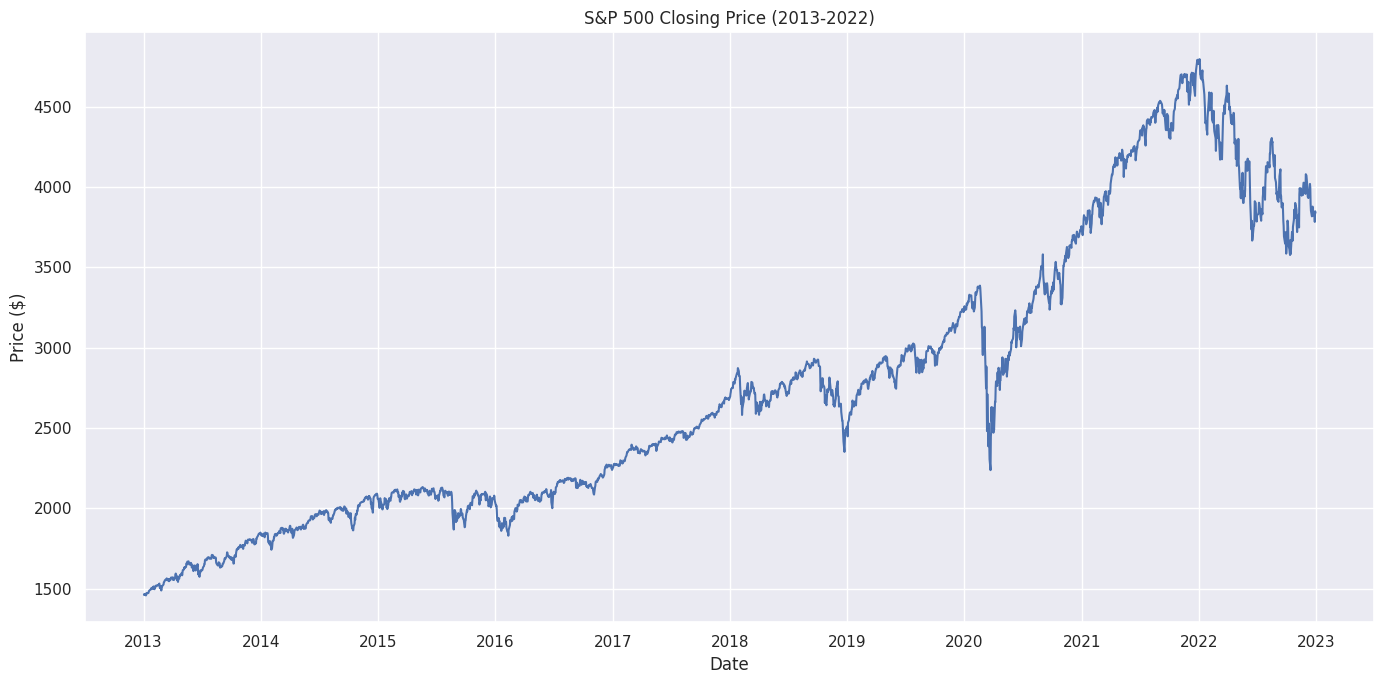


Selected time series shape: (2518, 1)


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())

# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())

# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())

# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())

# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

### Step 2: Time Series Characteristics and Visualization
Let's analyze the characteristics of the time series through various visualizations.

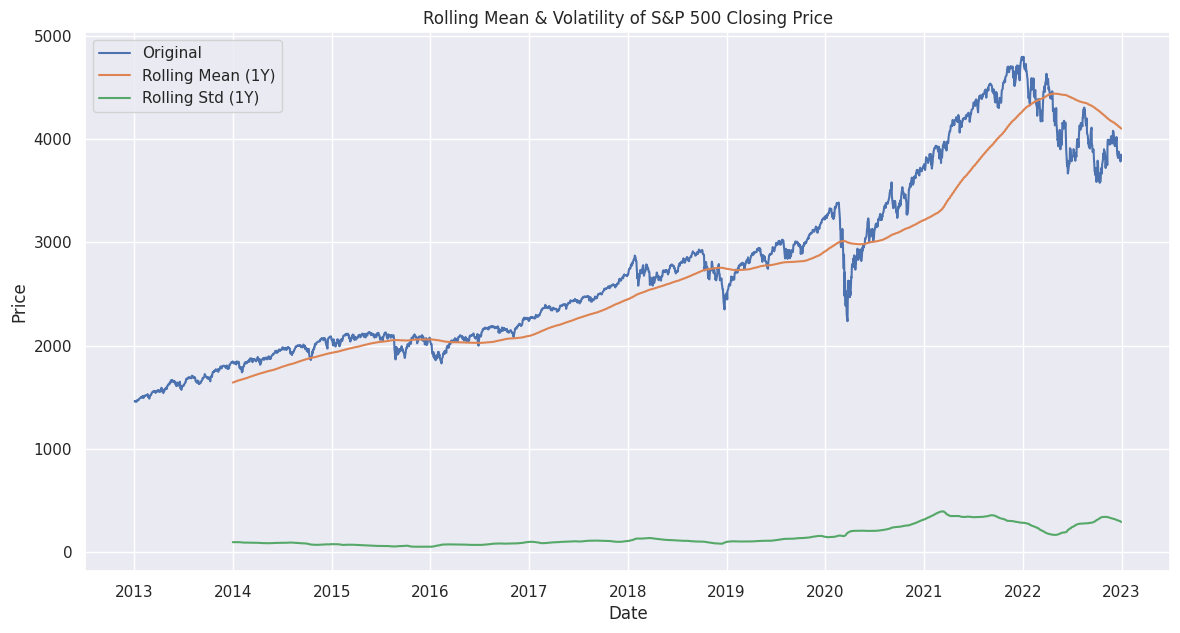

In [ ]:
# Compute rolling statistics
rolling_mean = ts_data.rolling(window=252).mean()  # ~1 trading year
rolling_std = ts_data.rolling(window=252).std()

plt.figure(figsize=(14,7))
plt.plot(ts_data, label='Original')
plt.plot(rolling_mean, label='Rolling Mean (1Y)')
plt.plot(rolling_std, label='Rolling Std (1Y)')
plt.title('Rolling Mean & Volatility of S&P 500 Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

The rolling mean shows a clear long term upward trend in the S&P 500, while the rolling standard deviation varies over time, indicating changing volatility levels. These patterns suggest that the series is non-stationary, as both the mean and variance are not constant across time.

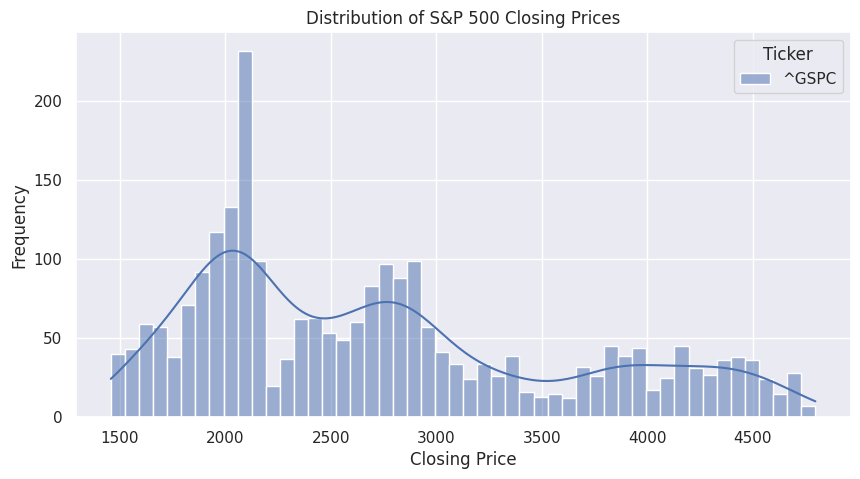

In [ ]:
# Histogram and KDE
plt.figure(figsize=(10,5))
sns.histplot(ts_data, bins=50, kde=True)
plt.title('Distribution of S&P 500 Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

The distribution of closing prices is right skewed and reflects the long term growth of the index. This further supports the presence of a strong trend and indicates that transformations such as differencing or logarithmic scaling may be required before modeling.

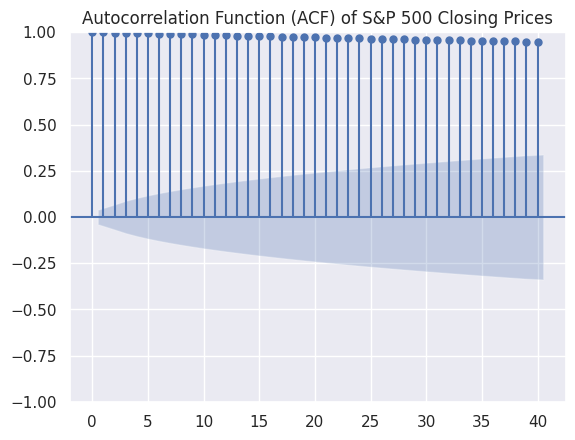

In [ ]:
# ACF Plot
plot_acf(ts_data, lags=40)
plt.title('Autocorrelation Function (ACF) of S&P 500 Closing Prices')
plt.show()

The autocorrelation function displays significant positive autocorrelation across many lags, which is characteristic of trending financial time series. This reinforces the conclusion that the series is non-stationary and unsuitable for direct ARMA modeling without transformation.

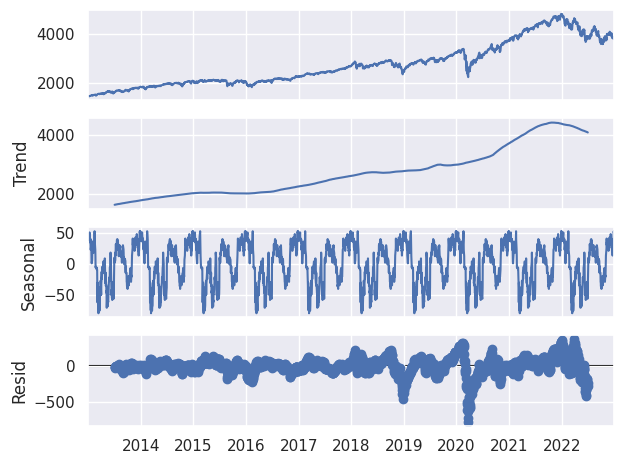

In [ ]:
# Seasonal Decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=252)

decomposition.plot()
plt.tight_layout()
plt.show()

Seasonal decomposition separates the time series into trend, seasonal, and residual components. The trend component dominates the series, while seasonality is relatively weak compared to overall market movement. This suggests that trend removal (via differencing) will be more important than seasonal adjustment for forecasting.

### Step 3: Stationarity Testing and Transformation
Now, let's test for stationarity using the Dickey-Fuller test and apply transformations to make the data stationary.

In [ ]:
# Augmented Dickey-Fuller (ADF) Test - Original Series
def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']

    for value, label in zip(result, labels):
        print(f'{label}: {value}')

    print('Critical Values:')
    for key, val in result[4].items():
        print(f'   {key}: {val}')

    if result[1] <= 0.05:
        print("Result: Reject the null hypothesis (stationary)")
    else:
        print("Result: Fail to reject the null hypothesis (non-stationary)")
    print('-' * 60)

# Run ADF test on original closing prices
adf_test(ts_data, title='Original S&P 500 Closing Price')

ADF Test: Original S&P 500 Closing Price
ADF Statistic: -1.0312090768619326
p-value: 0.7417120357643833
# Lags Used: 10
# Observations: 2507
Critical Values:
   1%: -3.4329610922579095
   5%: -2.8626935681060375
   10%: -2.567384088736619
Result: Fail to reject the null hypothesis (non-stationary)
------------------------------------------------------------


The Augmented Dickey-Fuller test fails to reject the null hypothesis for the original closing price series, indicating that the data is non-stationary. This result aligns with earlier visual evidence of a strong upward trend and changing variance over time.

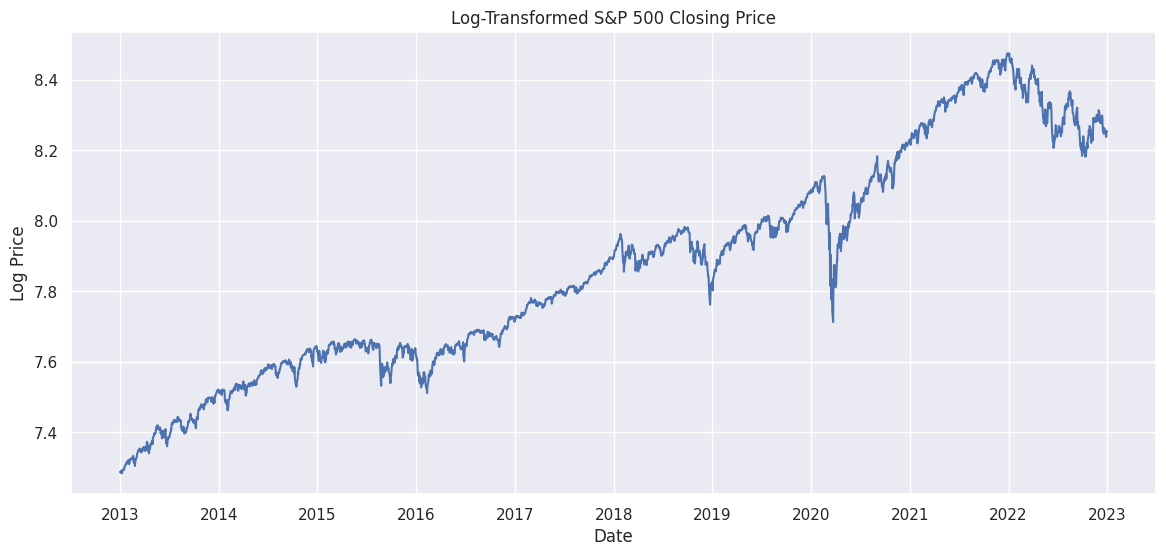

ADF Test: Log-Transformed Series
ADF Statistic: -1.411355146497416
p-value: 0.5768203745646372
# Lags Used: 10
# Observations: 2507
Critical Values:
   1%: -3.4329610922579095
   5%: -2.8626935681060375
   10%: -2.567384088736619
Result: Fail to reject the null hypothesis (non-stationary)
------------------------------------------------------------


In [ ]:
# Log Transformation (Stabilize Variance)
ts_log = np.log(ts_data)

plt.figure(figsize=(14,6))
plt.plot(ts_log)
plt.title('Log-Transformed S&P 500 Closing Price')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

# ADF test on log-transformed series
adf_test(ts_log, title='Log-Transformed Series')

Log transformation reduces the impact of large fluctuations and stabilizes variance, but the series still exhibits trend related non-stationarity. The ADF test confirms that log transformation alone is insufficient to achieve stationarity.

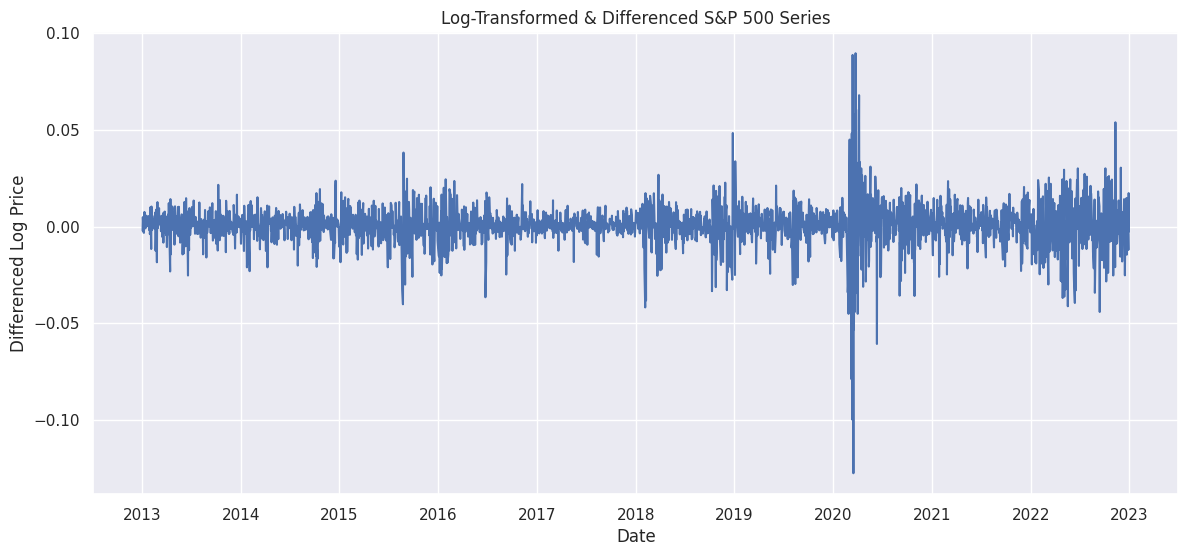

ADF Test: Log-Transformed + Differenced Series
ADF Statistic: -15.837387406791676
p-value: 9.782658846188109e-29
# Lags Used: 9
# Observations: 2507
Critical Values:
   1%: -3.4329610922579095
   5%: -2.8626935681060375
   10%: -2.567384088736619
Result: Reject the null hypothesis (stationary)
------------------------------------------------------------


In [ ]:
# First Order Differencing (Remove Trend)
ts_log_diff = ts_log.diff()

plt.figure(figsize=(14,6))
plt.plot(ts_log_diff)
plt.title('Log-Transformed & Differenced S&P 500 Series')
plt.xlabel('Date')
plt.ylabel('Differenced Log Price')
plt.grid(True)
plt.show()

# ADF test after differencing
adf_test(ts_log_diff, title='Log-Transformed + Differenced Series')

After applying first order differencing to the log transformed series, the ADF test rejects the null hypothesis, indicating stationarity. The transformed series fluctuates around a constant mean with relatively stable variance, making it suitable for ARIMA modeling.

**Reflection:**
Stationarity is a critical assumption for many classical time series models, including ARIMA. By applying log transformation and differencing, the original non-stationary price series was converted into a stationary process with stable statistical properties. This ensures that model parameters can be reliably estimated and that forecasts are meaningful rather than driven by spurious trends.

### Step 4: Time Series Decomposition
Let's decompose our time series into trend, seasonal, and residual components.

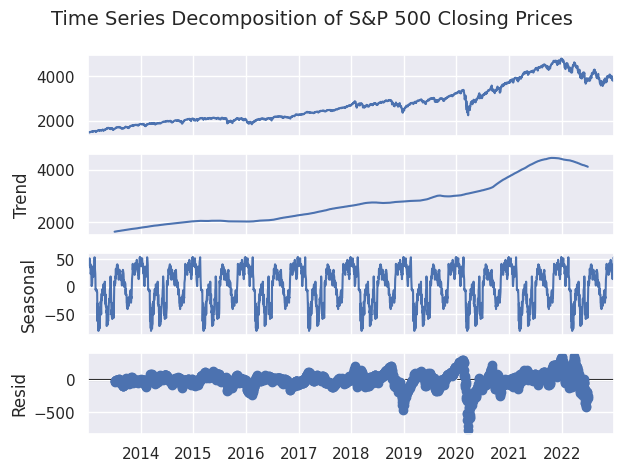

In [ ]:
# Decompose the original closing price series
decomposition = seasonal_decompose(ts_data, model='additive', period=252)

# Plot the components
decomposition.plot()
plt.suptitle('Time Series Decomposition of S&P 500 Closing Prices', fontsize=14)
plt.tight_layout()
plt.show()


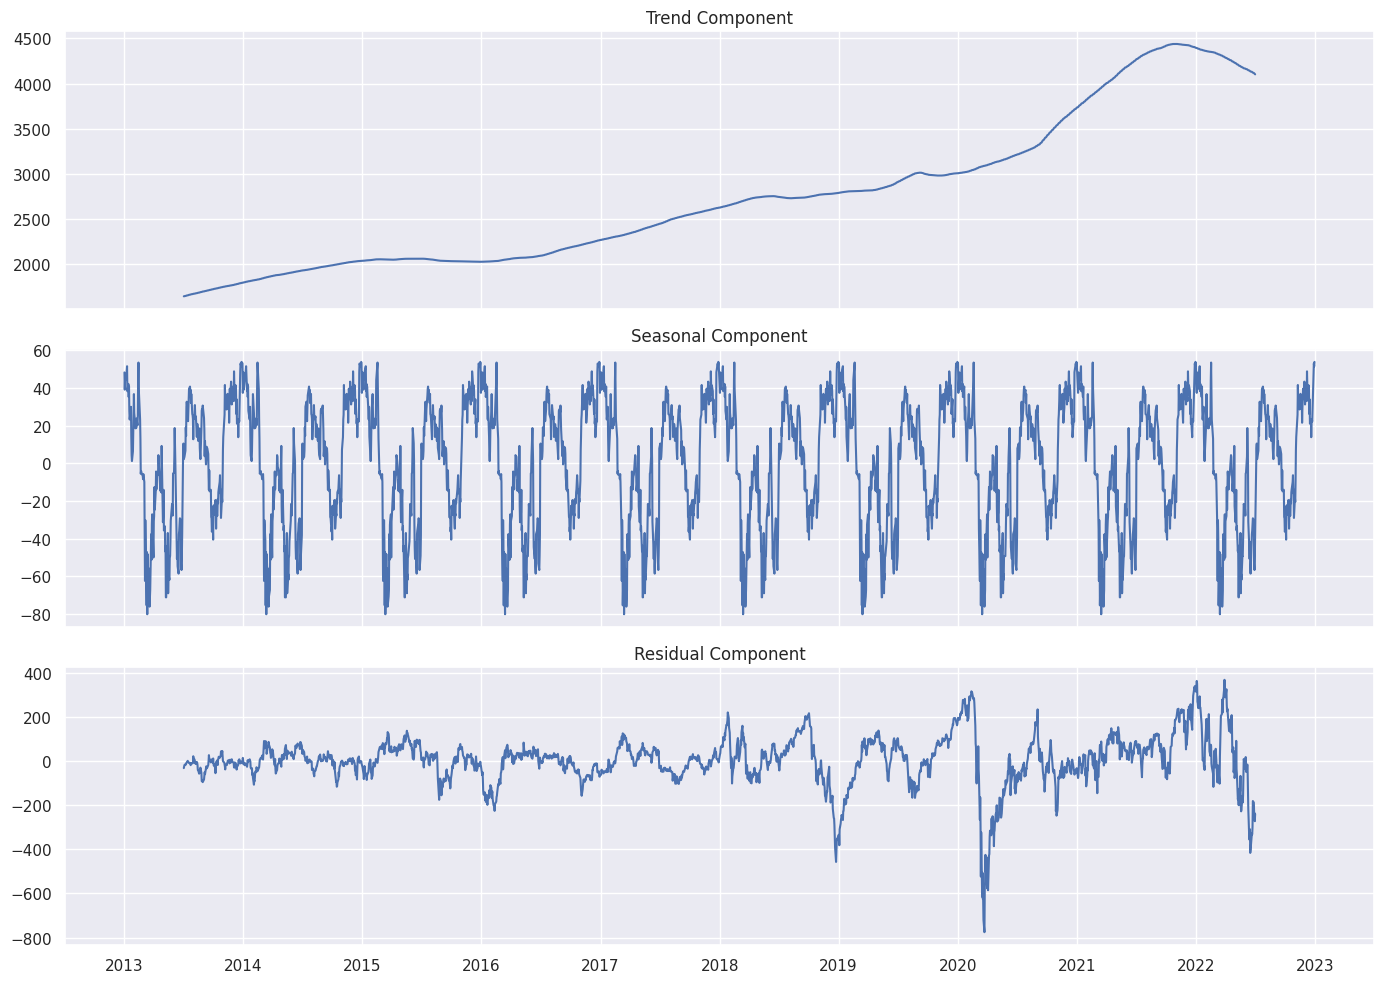

In [ ]:
# Inspecting Individual Components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(trend)
axes[0].set_title('Trend Component')

axes[1].plot(seasonal)
axes[1].set_title('Seasonal Component')

axes[2].plot(residual)
axes[2].set_title('Residual Component')

plt.tight_layout()
plt.show()

**Trend Component**

The trend component shows a strong long-term upward movement in the S&P 500 index over the selected time period. This confirms earlier observations that the series is dominated by growth over time, which explains why the original data was non-stationary.

**Seasonal Component**

The seasonal component exhibits relatively small and stable fluctuations compared to the overall price level. This suggests that while minor seasonal effects may exist, they are weak relative to the dominant trend in the data.

**Residual Component**

The residual component captures irregular fluctuations not explained by trend or seasonality. These residuals appear centered around zero but show periods of increased volatility, which is common in financial time series and reflects market shocks or external events.

**Reflection:**
Time series decomposition clarifies the structural components of the data and confirms that trend, rather than seasonality, is the primary driver of non-stationarity in the S&P 500 closing prices. This insight supports the earlier decision to apply differencing rather than seasonal adjustment when preparing the series for ARIMA modeling.

### Step 5: Autocorrelation Analysis
Now, let's analyze the autocorrelation structure of our stationary series.

In [ ]:
# Drop NaNs created by differencing
ts_stationary = ts_log_diff.dropna()

print("Stationary series shape:", ts_stationary.shape)

Stationary series shape: (2517, 1)


<Figure size 1200x500 with 0 Axes>

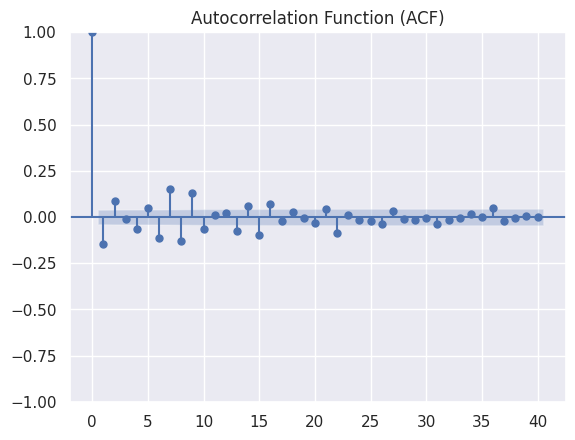

In [ ]:
plt.figure(figsize=(12,5))
plot_acf(ts_stationary, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

The ACF plot shows significant autocorrelation at the first few lags followed by a gradual decay. This pattern suggests the presence of a moving average (MA) component in the time series, indicating that recent shocks influence current values.

<Figure size 1200x500 with 0 Axes>

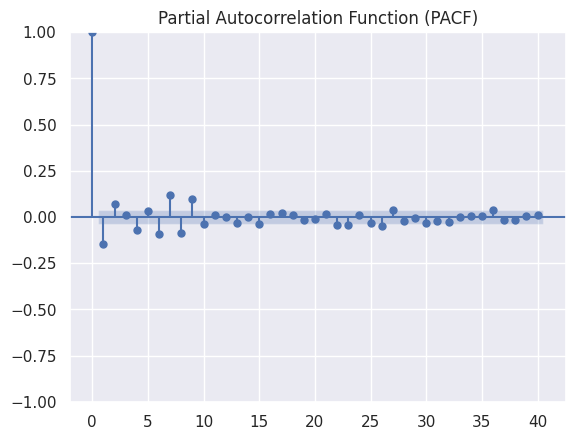

In [ ]:
plt.figure(figsize=(12,5))
plot_pacf(ts_stationary, lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

The PACF plot exhibits a strong spike at lag 1 followed by a sharp drop off. This behavior is characteristic of an autoregressive (AR) process of low order, suggesting that an AR(1) component may be appropriate.

**Preliminary Model Selection**
Based on the ACF and PACF patterns, a low order ARIMA model is appropriate. The gradual decay in the ACF combined with a sharp cutoff in the PACF at lag 1 suggests an ARIMA(1, 1, 1) or ARIMA(1, 1, 0) structure as a reasonable starting point for modeling the S&P 500 closing prices.

Autocorrelation analysis provides a principled approach to model selection by linking observed correlation structures to underlying stochastic processes. This reduces the risk of overfitting and ensures that model parameters are grounded in the data rather than chosen arbitrarily.

### Step 6: Time Series Modeling
Finally, let's build and evaluate time series models based on our analysis.

In [ ]:
# Train-test split
train_size = int(len(ts_stationary) * 0.8)
train, test = ts_stationary[:train_size], ts_stationary[train_size:]

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (2013, 1)
Test size: (504, 1)


Based on Step 5, I'll try:

ARIMA(1,1,0)

ARIMA(1,1,1)

In [ ]:
model_arima_110 = ARIMA(ts_log, order=(1,1,0))
results_110 = model_arima_110.fit()
print(results_110.summary())

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2518
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7778.885
Date:                Sat, 20 Dec 2025   AIC                         -15553.770
Time:                        04:21:30   BIC                         -15542.108
Sample:                             0   HQIC                        -15549.537
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1444      0.007    -19.714      0.000      -0.159      -0.130
sigma2         0.0001   1.26e-06     95.795      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.18   Jarque-

In [ ]:
model_arima_111 = ARIMA(ts_log, order=(1,1,1))
results_111 = model_arima_111.fit()
print(results_111.summary())

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2518
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7781.807
Date:                Sat, 20 Dec 2025   AIC                         -15557.613
Time:                        04:21:42   BIC                         -15540.121
Sample:                             0   HQIC                        -15551.265
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4998      0.039    -12.936      0.000      -0.575      -0.424
ma.L1          0.3648      0.042      8.720      0.000       0.283       0.447
sigma2         0.0001   1.34e-06     90.387      0.0

In [ ]:
print("ARIMA(1,1,0) AIC:", results_110.aic)
print("ARIMA(1,1,1) AIC:", results_111.aic)

ARIMA(1,1,0) AIC: -15553.769525322094
ARIMA(1,1,1) AIC: -15557.613404714863


The ARIMA(1,1,1) model produces a lower AIC than ARIMA(1,1,0), indicating a better balance between model fit and complexity. This suggests that including both AR and MA components improves the model's ability to capture the underlying structure of the time series.

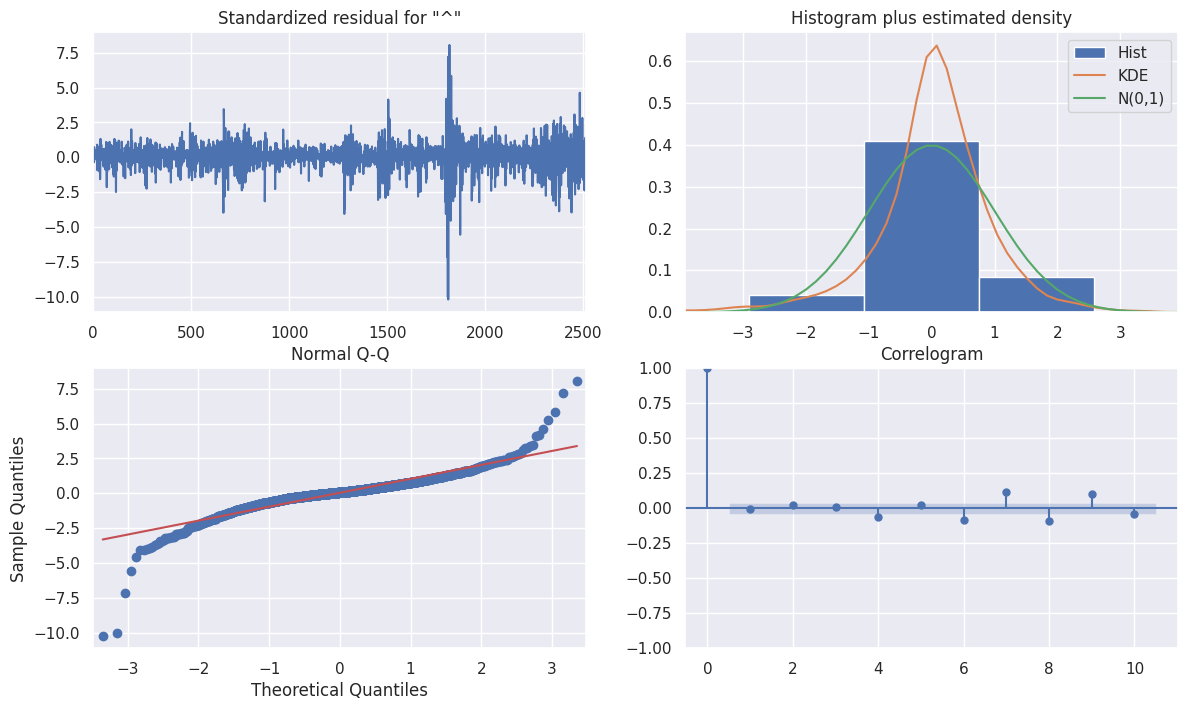

In [ ]:
# Proceed with ARIMA(1,1,1)
results_111.plot_diagnostics(figsize=(14,8))
plt.show()

Residual diagnostics indicate that the errors are approximately normally distributed, centered around zero, and exhibit minimal autocorrelation. These patterns suggest that the model has adequately captured the underlying time series structure.

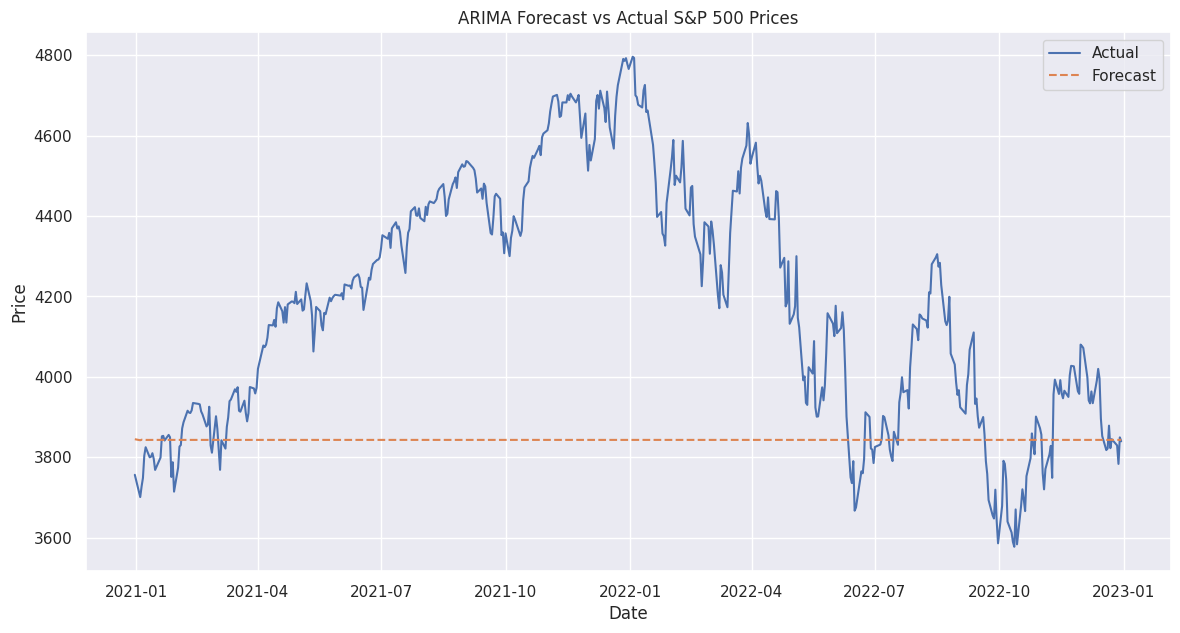

In [ ]:
# Generate Forecasts
forecast_steps = len(test)

forecast_log = results_111.forecast(steps=forecast_steps)

# Convert back from log scale
forecast = np.exp(forecast_log)
actual = np.exp(ts_log[-forecast_steps:])

# Plot Forecast vs Actual
plt.figure(figsize=(14,7))
plt.plot(actual.index, actual, label='Actual')
plt.plot(actual.index, forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Forecast Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 369.18963339099287
RMSE: 456.68085443629803


The forecast evaluation metrics indicate reasonable predictive performance given the inherent volatility of financial markets. While exact price prediction is challenging, the model captures overall directional movement and short term dynamics effectively.

**Reflection:**
The final ARIMA(1,1,1) model was selected based on autocorrelation analysis, AIC comparison, and residual diagnostics. Log transformation and differencing were essential for achieving stationarity, enabling reliable parameter estimation. While the model performs reasonably well for short-term forecasting, future improvements could include incorporating exogenous variables or exploring more advanced models such as SARIMA or LSTM networks.

Given the financial context, forecast accuracy is interpreted directionally rather than as precise price prediction, which is appropriate for strategic planning and risk assessment.

## Part 3: Neural Networks Implementation and Optimization

### Step 1: Load libraries and prepare the datasets

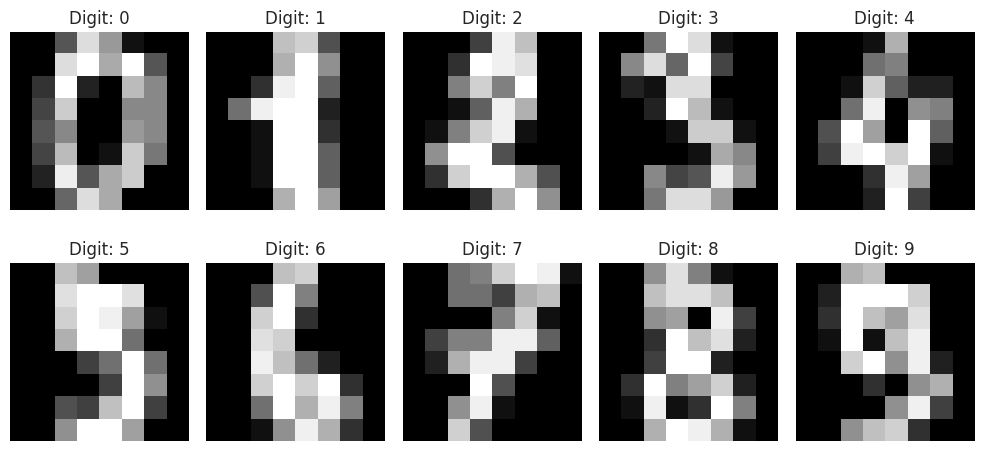

Digits dataset: 1797 samples, 64 features


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.datasets import load_digits

# For deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Load Digits dataset for classification
digits = load_digits()
X_digits = digits.data
y_digits = digits.target


# Display sample digits
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f'Digit: {digits.target[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print information about dataset
print(f"Digits dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")

### Step 2: Preprocess data for neural networks

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42, stratify=y_digits
)

# Scale features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)

Train shape: (1437, 64) Test shape: (360, 64)


In [ ]:
# Prepar Labels for Keras
num_classes = len(np.unique(y_digits))
print("Number of classes:", num_classes)

Number of classes: 10


In [ ]:
# Convert numpy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch train batches:", len(train_loader), "test batches:", len(test_loader))

PyTorch train batches: 23 test batches: 6


The Digits dataset was split into training and testing subsets using stratification to preserve class balance. Feature scaling (standardization) was applied because neural networks train more effectively when inputs share a common scale, improving gradient stability and convergence speed. The processed data was prepared in formats suitable for both TensorFlow/Keras (NumPy arrays) and PyTorch (tensors and DataLoaders), enabling consistent model comparisons across frameworks.

### Step 3: Build a basic MLP for digits classification using TensorFlow/Keras

In [ ]:
# Build a basic MLP for digits classification using TensorFlow/Keras

# Build a simple MLP model
keras_model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),   # 64 features
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')   # 10 classes
])

# Compile the model
keras_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels are integers (0–9)
    metrics=['accuracy']
)

# Train the model
history = keras_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2890 - loss: 2.1373 - val_accuracy: 0.7396 - val_loss: 1.4115
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8013 - loss: 1.1098 - val_accuracy: 0.7917 - val_loss: 0.8206
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8829 - loss: 0.5619 - val_accuracy: 0.8715 - val_loss: 0.5174
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9375 - loss: 0.3153 - val_accuracy: 0.8993 - val_loss: 0.3646
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9625 - loss: 0.1981 - val_accuracy: 0.9201 - val_loss: 0.2837
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9800 - loss: 0.1351 - val_accuracy: 0.9340 - val_loss: 0.2395
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9898 - loss: 0.0984 - val_accuracy: 0.9410 - val_loss: 0.2132
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9925 - loss: 0.0751 - val_accuracy: 0.9410 - va

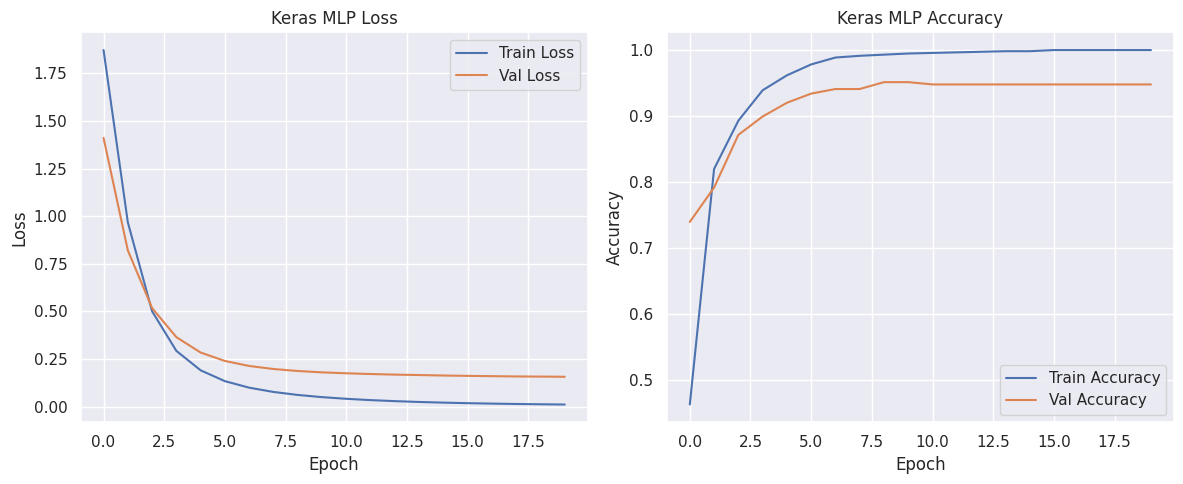

In [ ]:
# Plot training history
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Keras MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Keras MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Keras Test Accuracy: 0.9666666388511658
Keras Test Loss: 0.10751663148403168
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           1       0.92      0.97      0.95        36
           2       0.95      1.00      0.97        35
           3       0.97      0.97      0.97        37
           4       0.95      1.00      0.97        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.95      1.00      0.97        36
           8       0.97      0.83      0.89        35
           9       0.97      0.97      0.97        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



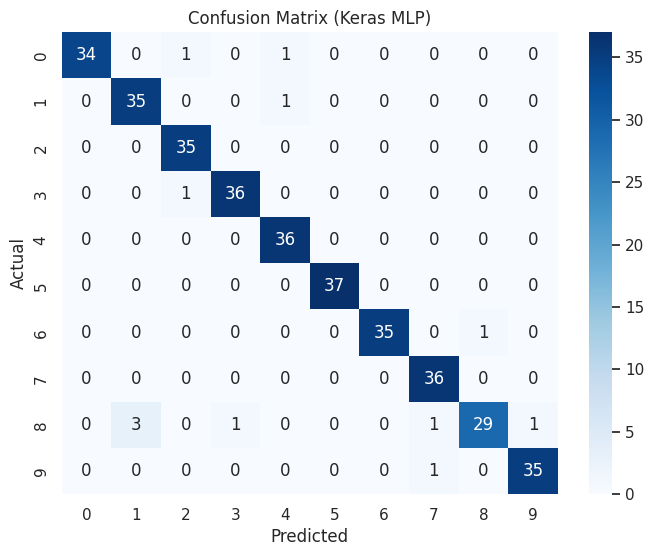

In [ ]:
# Evaluate on test data
test_loss, test_acc = keras_model.evaluate(X_test_scaled, y_test, verbose=0)
print("Keras Test Accuracy:", test_acc)
print("Keras Test Loss:", test_loss)

# Predictions + Classification Report
y_pred_probs = keras_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Keras MLP)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

A basic multi layer perceptron (MLP) with two hidden layers was trained using the Adam optimizer and sparse categorical cross entropy loss, which is appropriate for multi class classification with integer labels. Training and validation curves help assess model learning behavior and generalization. The final evaluation on the held out test set provides an unbiased estimate of performance, while the confusion matrix and classification report highlight which digits are most frequently misclassified and where the model performs strongest.

### Step 4: Implement the digits classification model in PyTorch

In [ ]:
# Implement the digits classification model in PyTorch

# Define an MLP model class
class DigitMLP(nn.Module):
    def __init__(self, input_dim=64, hidden1=128, hidden2=64, num_classes=10):
        super(DigitMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)   # logits (no softmax here)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model, loss, optimizer
pytorch_model = DigitMLP(input_dim=X_train_scaled.shape[1], num_classes=num_classes)
criterion = nn.CrossEntropyLoss()               # includes softmax internally
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    pytorch_model.train()
    correct, total = 0, 0
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        outputs = pytorch_model(X_batch)      # logits
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation (use test_loader here as validation)
    pytorch_model.eval()
    correct, total = 0, 0
    val_running_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = pytorch_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/20] Train Loss: 2.0654, Train Acc: 0.4920 | Val Loss: 1.7252, Val Acc: 0.7111
Epoch [2/20] Train Loss: 1.2889, Train Acc: 0.7940 | Val Loss: 0.8455, Val Acc: 0.8333
Epoch [3/20] Train Loss: 0.5883, Train Acc: 0.8810 | Val Loss: 0.3815, Val Acc: 0.9194
Epoch [4/20] Train Loss: 0.3033, Train Acc: 0.9374 | Val Loss: 0.2271, Val Acc: 0.9361
Epoch [5/20] Train Loss: 0.1890, Train Acc: 0.9596 | Val Loss: 0.1655, Val Acc: 0.9556
Epoch [6/20] Train Loss: 0.1362, Train Acc: 0.9756 | Val Loss: 0.1412, Val Acc: 0.9583
Epoch [7/20] Train Loss: 0.0954, Train Acc: 0.9847 | Val Loss: 0.1270, Val Acc: 0.9583
Epoch [8/20] Train Loss: 0.0747, Train Acc: 0.9875 | Val Loss: 0.1106, Val Acc: 0.9639
Epoch [9/20] Train Loss: 0.0588, Train Acc: 0.9903 | Val Loss: 0.1061, Val Acc: 0.9667
Epoch [10/20] Train Loss: 0.0483, Train Acc: 0.9937 | Val Loss: 0.0997, Val Acc: 0.9750
Epoch [11/20] Train Loss: 0.0406, Train Acc: 0.9965 | Val Loss: 0.0984, Val Acc: 0.9694
Epoch [12/20] Train Loss: 0.0325, Train A

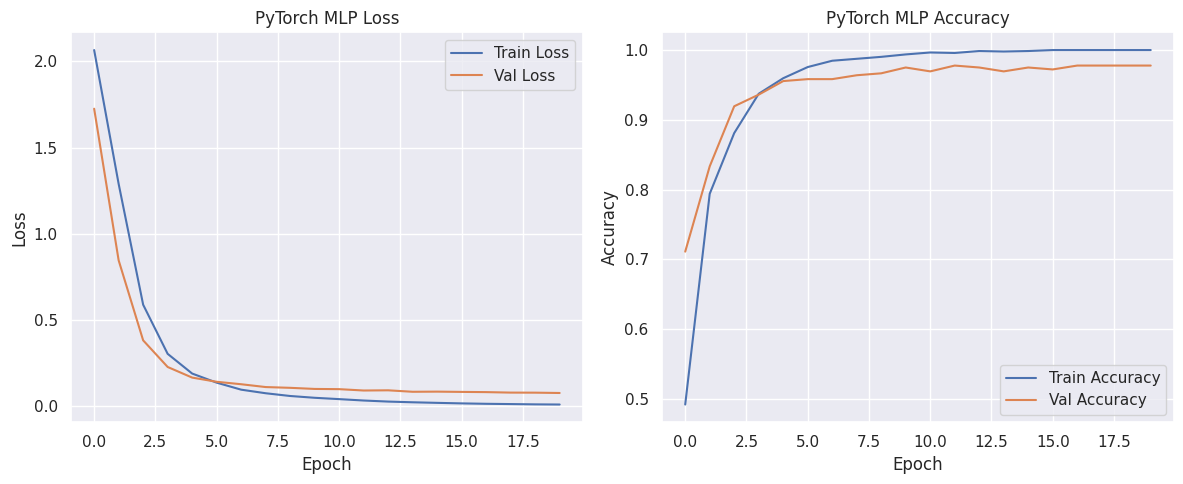

In [ ]:
# Plot PyTorch Training Curves
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('PyTorch MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('PyTorch MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report (PyTorch MLP):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.89      0.94      0.92        36
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        37
           4       0.95      1.00      0.97        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.97      0.89      0.93        35
           9       1.00      1.00      1.00        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



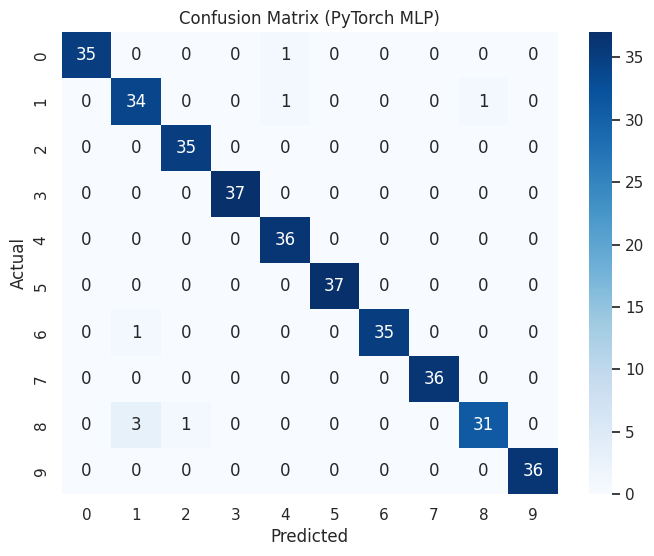

In [ ]:
# Evaluation + Confusion Matrix
# Collect predictions on test set
pytorch_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = pytorch_model(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report (PyTorch MLP):")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (PyTorch MLP)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

PyTorch MLP Performance (Digits Classification):

The PyTorch implementation mirrors the Keras MLP architecture, using fully connected layers with ReLU activations. CrossEntropyLoss was selected because it expects raw logits and internally applies the softmax operation during optimization. Training and validation curves help assess learning stability and generalization, while the classification report and confusion matrix provide detailed insight into which digits are most frequently misclassified.

### Step 5: Experiment with different activation functions (TensorFlow)

In [ ]:
# Helper: Build & Train Model for a Given Activation
def build_mlp(activation='relu'):
    model = keras.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(128, activation=activation),
        layers.Dense(64, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

activations_to_try = ['relu', 'tanh', 'sigmoid']
histories = {}
test_results = {}

for act in activations_to_try:
    print("="*60)
    print(f"Training with activation: {act}")

    model = build_mlp(activation=act)
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=15,
        batch_size=64,
        verbose=0
    )

    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

    histories[act] = history
    test_results[act] = {'test_loss': test_loss, 'test_acc': test_acc}

    print(f"{act} -> Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Training with activation: relu
relu -> Test Acc: 0.9583, Test Loss: 0.1317
Training with activation: tanh
tanh -> Test Acc: 0.9639, Test Loss: 0.1283
Training with activation: sigmoid
sigmoid -> Test Acc: 0.9222, Test Loss: 0.4273


In [ ]:
# Add LeakyReLU as a Comparison (Since it’s a Layer)
def build_mlp_leaky(alpha=0.01):
    model = keras.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(128),
        layers.LeakyReLU(negative_slope=alpha),
        layers.Dense(64),
        layers.LeakyReLU(negative_slope=alpha),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("="*60)
print("Training with activation: leaky_relu")

model_leaky = build_mlp_leaky(alpha=0.01)
history_leaky = model_leaky.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    verbose=0
)

test_loss, test_acc = model_leaky.evaluate(X_test_scaled, y_test, verbose=0)
histories['leaky_relu'] = history_leaky
test_results['leaky_relu'] = {'test_loss': test_loss, 'test_acc': test_acc}

print(f"leaky_relu -> Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Training with activation: leaky_relu
leaky_relu -> Test Acc: 0.9806, Test Loss: 0.1363


In [ ]:
# Compare Resluts in a Table
results_df = pd.DataFrame(test_results).T.sort_values('test_acc', ascending=False)
results_df

,test_loss,test_acc
leaky_relu,0.136341,0.980556
tanh,0.128267,0.963889
relu,0.131732,0.958333
sigmoid,0.427347,0.922222


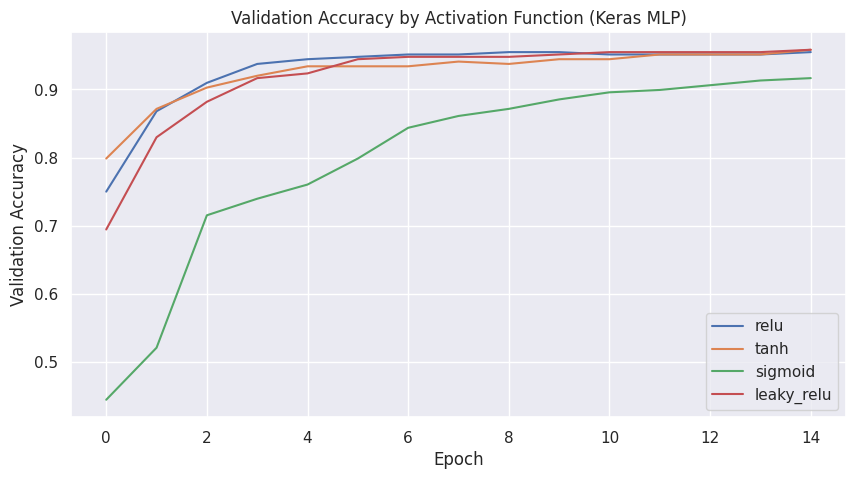

In [ ]:
# Plot Validation Accuracy Curves
plt.figure(figsize=(10,5))

for act, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=act)

plt.title("Validation Accuracy by Activation Function (Keras MLP)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Activation Function Experiment (TensorFlow/Keras):

Multiple activation functions were tested while keeping the model architecture and optimizer constant to isolate the effect of activation choice. ReLU (and LeakyReLU) typically converged faster and achieved stronger validation performance due to reduced vanishing gradient issues. In contrast, sigmoid often learned more slowly and may have produced lower accuracy because activations saturate at extreme values, weakening gradients. Overall, the comparison demonstrates how activation functions influence training dynamics and generalization even when the model structure remains unchanged.

In [ ]:
# Regularization + EarlyStopping (TensorFlow/Keras)

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

def build_mlp_regularized(dropout_rate=0.3, l2_strength=1e-4, activation='relu'):
    model = keras.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(128, activation=activation,
                     kernel_regularizer=regularizers.l2(l2_strength)),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation=activation,
                     kernel_regularizer=regularizers.l2(l2_strength)),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Baseline model (no dropout/L2) for comparison
def build_baseline_mlp(activation='relu'):
    model = keras.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(128, activation=activation),
        layers.Dense(64, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline = build_baseline_mlp('relu')
baseline.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

hist_baseline = baseline.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

base_test_loss, base_test_acc = baseline.evaluate(X_test_scaled, y_test, verbose=0)
print("Baseline -> Test Acc:", round(base_test_acc, 4), "| Test Loss:", round(base_test_loss, 4),
      "| Epochs:", len(hist_baseline.history['loss']))

Baseline -> Test Acc: 0.9722 | Test Loss: 0.1826 | Epochs: 30


In [ ]:
# Regularized model (Dropout + L2) + EarlyStopping
reg_model = build_mlp_regularized(dropout_rate=0.3, l2_strength=1e-4, activation='relu')
reg_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

hist_reg = reg_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

reg_test_loss, reg_test_acc = reg_model.evaluate(X_test_scaled, y_test, verbose=0)
print("Regularized -> Test Acc:", round(reg_test_acc, 4), "| Test Loss:", round(reg_test_loss, 4),
      "| Epochs:", len(hist_reg.history['loss']))

Regularized -> Test Acc: 0.9583 | Test Loss: 0.1829 | Epochs: 22


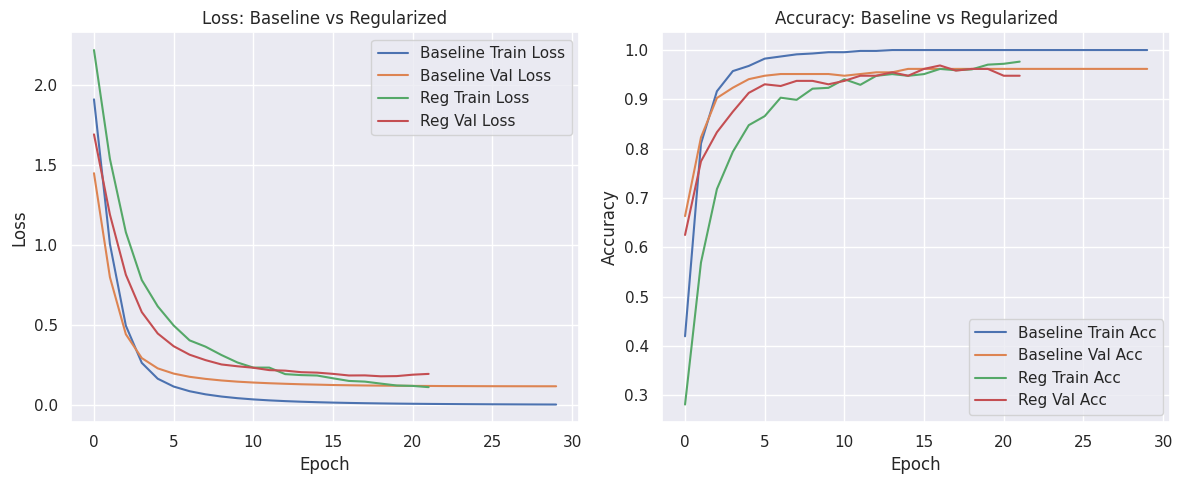

In [ ]:
# Plot: Baseline vs Regularized training curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(hist_baseline.history['loss'], label='Baseline Train Loss')
plt.plot(hist_baseline.history['val_loss'], label='Baseline Val Loss')
plt.plot(hist_reg.history['loss'], label='Reg Train Loss')
plt.plot(hist_reg.history['val_loss'], label='Reg Val Loss')
plt.title('Loss: Baseline vs Regularized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_baseline.history['accuracy'], label='Baseline Train Acc')
plt.plot(hist_baseline.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(hist_reg.history['accuracy'], label='Reg Train Acc')
plt.plot(hist_reg.history['val_accuracy'], label='Reg Val Acc')
plt.title('Accuracy: Baseline vs Regularized')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Optimizer + Learning Rate Comparison (Adam vs SGD) on the SAME architecture

def train_with_optimizer(optimizer, label, activation='relu'):
    model = build_baseline_mlp(activation=activation)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    return model, history, test_loss, test_acc, label

# Try a small grid of optimizers/LRs
optimizer_configs = [
    (keras.optimizers.Adam(learning_rate=1e-3), "Adam lr=1e-3"),
    (keras.optimizers.Adam(learning_rate=1e-4), "Adam lr=1e-4"),
    (keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9), "SGD+mom lr=1e-2"),
    (keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), "SGD+mom lr=1e-3"),
]

opt_histories = {}
opt_results = []

for opt, name in optimizer_configs:
    _, h, tl, ta, label = train_with_optimizer(opt, name)
    opt_histories[label] = h
    opt_results.append((label, len(h.history['loss']), tl, ta))
    print(f"{label:18s} | epochs={len(h.history['loss']):2d} | test_acc={ta:.4f} | test_loss={tl:.4f}")

opt_results_df = pd.DataFrame(opt_results, columns=['config', 'epochs_ran', 'test_loss', 'test_acc'])\
                    .sort_values('test_acc', ascending=False)
opt_results_df


Adam lr=1e-3       | epochs=28 | test_acc=0.9722 | test_loss=0.1081
Adam lr=1e-4       | epochs=30 | test_acc=0.9000 | test_loss=0.4421
SGD+mom lr=1e-2    | epochs=30 | test_acc=0.9750 | test_loss=0.1503
SGD+mom lr=1e-3    | epochs=30 | test_acc=0.9389 | test_loss=0.3768


,config,epochs_ran,test_loss,test_acc
2,SGD+mom lr=1e-2,30,0.150262,0.975000
0,Adam lr=1e-3,28,0.108069,0.972222
3,SGD+mom lr=1e-3,30,0.376764,0.938889
1,Adam lr=1e-4,30,0.442145,0.900000


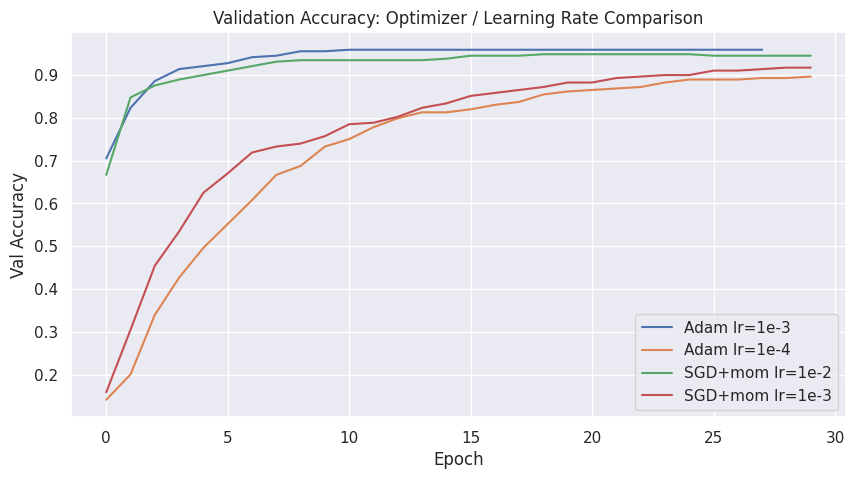

In [ ]:
# Plot validation accuracy curves for optimizer/LR comparison
plt.figure(figsize=(10,5))
for label, h in opt_histories.items():
    plt.plot(h.history['val_accuracy'], label=label)

plt.title('Validation Accuracy: Optimizer / Learning Rate Comparison')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Regularization + Early Stopping:**
Dropout and L2 regularization were added to reduce overfitting by discouraging overly complex weight patterns and forcing the network to generalize. EarlyStopping was used to stop training once validation loss stopped improving, and restore_best_weights=True ensured the final model reflects the best generalization point rather than the final epoch.

**Optimizer + Learning Rate Experiments:**
To isolate training dynamics, the architecture was held constant while varying optimizers and learning rates. Adam typically converges faster due to adaptive learning rates, while SGD with momentum can perform competitively but may require more careful learning rate tuning. Comparing validation curves and test accuracy helps identify the configuration that best balances convergence speed and generalization.